In [1]:
# Import modules
import numpy as np
import pandas as pd
import quandl
from itertools import combinations
from datetime import datetime
from datetime import timedelta


from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# Plotting preferences
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re

In [3]:
#Reading Apple app store data

df = pd.read_csv('app-store-apple-data-set-10k-apps/AppleStore.csv')

desc = pd.read_csv('app-store-apple-data-set-10k-apps/appleStore_description.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 17 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
dtypes: float64(3), int64(9), object(5)
memory usage: 955.9+ KB


In [5]:
df.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [7]:
#Checking to see if there are any apps duplicated in the dataset 

print(any(df['id'].duplicated()))

False


In [8]:
#Checking for null values

df.isnull().sum()

Unnamed: 0          0
id                  0
track_name          0
size_bytes          0
currency            0
price               0
rating_count_tot    0
rating_count_ver    0
user_rating         0
user_rating_ver     0
ver                 0
cont_rating         0
prime_genre         0
sup_devices.num     0
ipadSc_urls.num     0
lang.num            0
vpp_lic             0
dtype: int64

/Users/sirishat/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


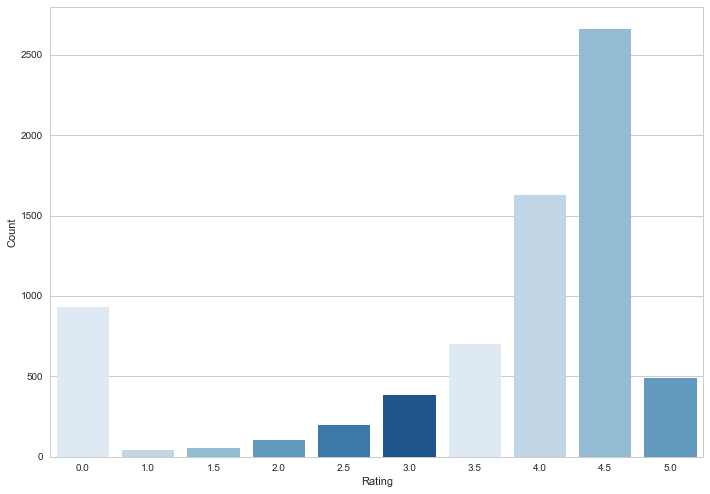

In [9]:
# Displaying the Rating frequency of the apps

sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style('whitegrid')
ax = sns.countplot(x='user_rating', data=df, palette=sns.color_palette('Blues'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

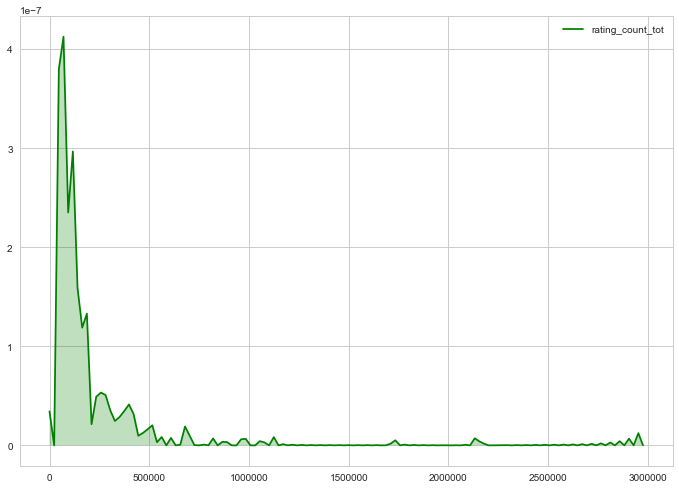

In [10]:
# Number of ratings per app KDE distribution

ax = sns.kdeplot(df['rating_count_tot'], shade=True, color='green')
plt.show()

# Simple Reco

In [11]:
#Calculating the mean rating for the app

C = df['user_rating'].mean()

print(C)

3.52695567598


In [13]:
#Calculating number of reviews per app that lie in the 80th percentile 

m = df['rating_count_tot'].quantile(0.80)

print(m)

4782.6


In [14]:
#Filtering out the apps based on the number of ratings 

filt_df = df.copy().loc[df['rating_count_tot']>=m]

filt_df.shape

(1440, 17)

In [15]:
# Function that computes the weighted rating of each app
def weighted_rating(x, m=m, C=C):
    v = x['rating_count_tot']
    R = x['user_rating']
    # Calculation based on the formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [16]:
# Define a new feature 'score' and calculate its value with the above function
filt_df['score'] = filt_df.apply(weighted_rating, axis=1)

In [17]:
filt_df.head(5)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,score
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,3.913234
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,3.986359
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,3.500667
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,3.991527
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,4.495303


In [18]:
#Sorting the dataframe based on the aboves calculated scores

filt_df = filt_df.sort_values('score', ascending=False)

In [19]:
#Print the top 15 apps
filt_df[['id','track_name', 'user_rating', 'rating_count_tot', 'score']].head(15)

,id,track_name,user_rating,rating_count_tot,score
1104,487119327,Head Soccer,5.0,481564,4.985514
302,350642635,Plants vs. Zombies,5.0,426463,4.983664
3086,930574573,Sniper 3D Assassin: Shoot to Kill Gun Game,5.0,386521,4.981996
2177,698255242,Geometry Dash Lite,5.0,370370,4.981221
498,387428400,Infinity Blade,5.0,326482,4.978733
1877,625334537,Geometry Dash,5.0,266440,4.974025
810,436491861,Domino's Pizza USA,5.0,258624,4.973254
2731,887947640,CSR Racing 2,5.0,257100,4.973099
1802,600674056,Pictoword: Fun 2 Pics Guess What's the Word Tr...,5.0,186089,4.963090
350,363282253,Plants vs. Zombies HD,5.0,163598,4.958160


# Collaborative Filtering

In [20]:
# Setting up the model

# Recommend 20 similar items
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points
data_points = filt_df[['user_rating', 'rating_count_tot', 'score']].values

#Training labels
labels = filt_df.index.values

print("Data points: ")
print(data_points)
print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[  5.00000000e+00   4.81564000e+05   4.98551448e+00]
 [  5.00000000e+00   4.26463000e+05   4.98366364e+00]
 [  5.00000000e+00   3.86521000e+05   4.98199612e+00]
 ..., 
 [  2.00000000e+00   1.35670000e+04   2.39798242e+00]
 [  2.00000000e+00   5.61700000e+04   2.11981143e+00]
 [  2.00000000e+00   1.87315000e+05   2.03801619e+00]]
Labels: 
[1104  302 3086 ...,  437  439   86]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [21]:
#Setting app name as index of the dataframe

filt_df = filt_df.set_index('track_name')

In [22]:
# Enter app name to get a list of 20 recommended items

# User entered value
app_name = 'Head Soccer'

app_data = [filt_df.loc[app_name][['user_rating','rating_count_tot','score']].values]

recommended_apps = engine.kneighbors(X=app_data, n_neighbors=20, return_distance=False)

# List of app names form the indexes

apps_list = []

for each in recommended_apps:
    apps_list.append(filt_df.iloc[each].index)

print("Recommended apps: ")
print(apps_list)

Recommended apps: 
[Index([u'Head Soccer', u'Google – Search made just for mobile',
       u'The Weather Channel: Forecast, Radar & Alerts',
       u'Despicable Me: Minion Rush', u'DragonVale',
       u'Calorie Counter & Diet Tracker by MyFitnessPal', u'PAC-MAN',
       u'The Sims™ FreePlay', u'Google Earth', u'Minecraft: Pocket Edition',
       u'Plants vs. Zombies', u'Clear Vision (17+)', u'Sonic Dash',
       u'Groupon - Deals, Coupons & Discount Shopping App', u'8 Ball Pool™',
       u'Tiny Tower - Free City Building', u'Jetpack Joyride',
       u'Bike Race - Top Motorcycle Racing Games',
       u'Shazam - Discover music, artists, videos & lyrics',
       u'Kim Kardashian: Hollywood'],
      dtype='object', name=u'track_name')]


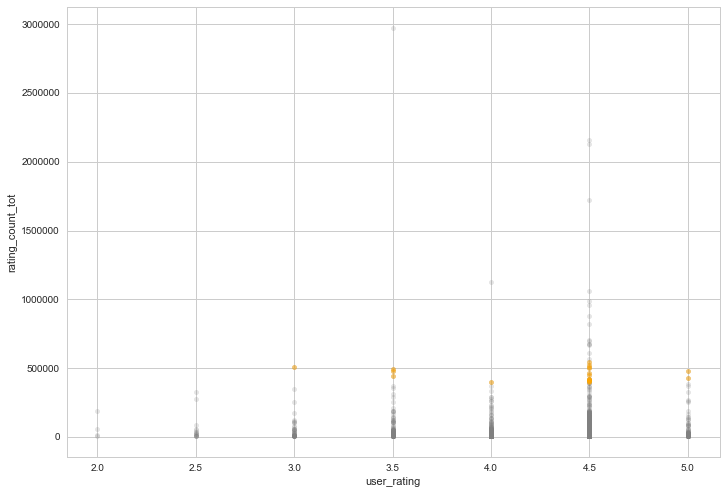

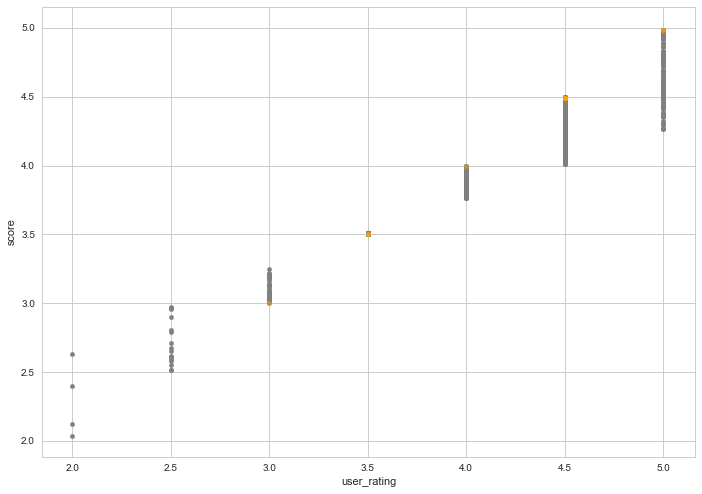

In [24]:
# Showing recommended apps

ax = filt_df.plot(kind='scatter', x='user_rating', y='rating_count_tot', color='grey', alpha=0.20)
filt_df.iloc[recommended_apps[0]].plot(kind='scatter', x='user_rating', y='rating_count_tot',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = filt_df.plot(kind='scatter', x='user_rating', y='score', color='grey')
filt_df.iloc[recommended_apps[0]].plot(kind='scatter', x='user_rating', y='score',\
                                                   color='orange', alpha=0.5, ax=ax2)


plt.show()

   # Content Based

In [26]:
#Based on app description

desc.head()

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...


In [27]:
desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 4 columns):
id            7197 non-null int64
track_name    7197 non-null object
size_bytes    7197 non-null int64
app_desc      7197 non-null object
dtypes: int64(2), object(2)
memory usage: 225.0+ KB


In [38]:
#Merging the app store and app description datasets 

combined_df = pd.merge(df,desc,on=['id','track_name','size_bytes'],how='inner')

In [39]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7197 entries, 0 to 7196
Data columns (total 18 columns):
Unnamed: 0          7197 non-null int64
id                  7197 non-null int64
track_name          7197 non-null object
size_bytes          7197 non-null int64
currency            7197 non-null object
price               7197 non-null float64
rating_count_tot    7197 non-null int64
rating_count_ver    7197 non-null int64
user_rating         7197 non-null float64
user_rating_ver     7197 non-null float64
ver                 7197 non-null object
cont_rating         7197 non-null object
prime_genre         7197 non-null object
sup_devices.num     7197 non-null int64
ipadSc_urls.num     7197 non-null int64
lang.num            7197 non-null int64
vpp_lic             7197 non-null int64
app_desc            7197 non-null object
dtypes: float64(3), int64(9), object(6)
memory usage: 1.0+ MB


In [30]:
combined_df['app_desc'].head()

0    SAVE 20%, now only $3.99 for a limited time!\n...
1    Let Evernote change the way you organize your ...
2    Download the most popular free weather app pow...
3    The eBay app is the best way to find anything ...
4    On more than 250 million devices around the wo...
Name: app_desc, dtype: object

In [31]:
# need to computer word vectors of each app

#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
combined_df['app_desc'] = combined_df['app_desc'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(combined_df['app_desc'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(7197, 95415)

In [32]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [40]:
#Construct a reverse map of indices and app titles
indices = pd.Series(combined_df.index, index=combined_df['track_name']).drop_duplicates()

In [41]:
# Function that takes in app title as input and outputs most similar app
def get_recommendations(app, cosine_sim=cosine_sim):
    # Get the index of the app that matches the title
    idx = indices[app]

    # Get the pairwsie similarity scores of all apps with that app
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the apps based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar apps
    sim_scores = sim_scores[1:26]

    # Get the app indices
    app_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar apps
    return combined_df['track_name'].iloc[app_indices]

In [42]:
get_recommendations('Head Soccer')

3561                                      Head Basketball
2501                                        Soccer Stars™
6834                                            Soccer 17
5963                                 Stickman Soccer 2016
2746                        Soccer Star 2016 World Legend
275                                           Angry Birds
368                                        Angry Birds HD
3330    Play Basketball Hoops 2017 - Real slam dunks game
7023                                        Dumber League
937                 Top Eleven 2017 - Be a Soccer Manager
2626                                     Pixel Cup Soccer
5664                                  Pixel Cup Soccer 16
6315                                    NBC Sports Scores
3950                             Dream League Soccer 2017
4594                                  Pelé: Soccer Legend
3082                                     PES CLUB MANAGER
6324                                      Ketchapp Soccer
1308          

In [45]:
get_recommendations('Evernote - stay organized')

4354             FastEver 2 - Quick memo app for Evernote
535                                             Noteshelf
2318      Notepad+: Take Notes, Annotate and Write on PDF
3931      Whink - Note taking, Annotate & Record Lectures
654                                     Microsoft OneNote
344                                            Notability
3359               Carbo - Handwriting in the Digital Age
228                     ScanBizCards Business Card Reader
4019                                                 Bear
508            CamScanner +| PDF Document Scanner and OCR
1213    Paper by FiftyThree - Sketch, Diagram, Take Notes
426                                            Notes Plus
188                                          Epson iPrint
1522    MetaMoJi Note - note taking and PDF annotation...
5481                                               Jottit
639                                SecurityCam for iPhone
3607     Scanner For Me - PDF Scan with OCR for Documents
4962          

In [46]:
#Improving the above recommender system by incorporating a popularity filter - based on ratings and reviews for the
# top 30 most similar apps. This filters out the top 10 apps most similar to the given app along with being the 
# highest rated with most rating counts as well. 

def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    app_indices = [i[0] for i in sim_scores]
    
    apps = combined_df.iloc[app_indices][['track_name', 'user_rating', 'rating_count_tot']]
    rating = apps[apps['user_rating'].notnull()]['user_rating'].astype('int')
    rating_count = apps[apps['rating_count_tot'].notnull()]['rating_count_tot'].astype('int')
    C = rating.mean()
    m = rating_count.quantile(0.60)
    qual = apps[(apps['rating_count_tot'] >= m) & (apps['user_rating'].notnull())]
    qual['user_rating'] = qual['user_rating'].astype('int')
    qual['rating_count_tot'] = qual['rating_count_tot'].astype('int')
    qual['score'] = qual.apply(weighted_rating, axis=1)
    qual = qual.sort_values('score', ascending=False).head(10)
    return qual

In [47]:
improved_recommendations('Head Soccer')

/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/sirishat/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

,track_name,user_rating,rating_count_tot,score
275,Angry Birds,4,824451,3.997272
368,Angry Birds HD,4,89110,3.975905
2559,Score! Hero,4,85395,3.974912
3950,Dream League Soccer 2017,4,66004,3.968039
2501,Soccer Stars™,4,43216,3.952866
3561,Head Basketball,4,18037,3.900858
937,Top Eleven 2017 - Be a Soccer Manager,4,14104,3.880212
1123,Fresh Tracks Snowboarding,4,10107,3.848056
2746,Soccer Star 2016 World Legend,4,7765,3.819696
1203,CoPilot GPS – Car Navigation & Offline Maps,4,3582,3.729529
